<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/08_mrs_and_mrsi/notebooks/writePRESS_tl_(basic).ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example SVS PRESS sequence

The code implements SVS PRESS sequence with quite optimized gradient shapes but neither water suppression nor other bells-and-wistles

**Exercises** can be found at the end of this notebook

# Initial package set-up
This is a necessary step for the Colab environment, and it is only slow on the first run

In [35]:
try:
  import pypulseq as mr
  print("pypulseq package is readily available\n")

except ImportError or ModuleNotFoundError:
  !pip install git+https://github.com/imr-framework/pypulseq.git
  #!pip install git+https://github.com/FrankZijlstra/pypulseq.git@bugfixes

pypulseq package is readily available



# Python imports

In [36]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt

import pypulseq as mr

# Set high-level sequence parameters
Use the code block below to set high-level parameters such as FOV, spatial resolution, etc...

In [37]:
# Define the voxel size and other parameters

voxel_mm=[20,30,40] # voxel size in mm
Nx=4096
Nrep=16
adcDur=2048e-3
rfDurEx=2600e-6
rfDurRef=5200e-6
TR=3000e-3
TE=142e-3
spA=0.6e3 # spoiler area in 1/m (=Hz/m*s)
spB=2.0e3 # spoiler area in 1/m (=Hz/m*s)

# Set system limits
# in spectroscopy sequences we typically set very conservative limits, much lower
# than the actual system cpapabilities to avoid eddy currents and gradien heating

system = mr.Opts(
    max_grad=15,
    grad_unit="mT/m",
    max_slew=100,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=20e-6,
)

# More advansed options and switches
plot: bool = True
write_seq: bool = True
seq_filename: str = "press_pypulseq.seq"
voxel = np.array(voxel_mm)*1e-3;

# Create Pulseq objects
Create all kinds of objects that we will need in the sequence, such as the slice selective RF pulse, slice selection and refocusing gradients, etc...

In [38]:
# Create slice-selective excitation and refocusing pulses
rf_ex, g_ex, g_exReph = mr.make_sinc_pulse(flip_angle=np.pi/2,duration=rfDurEx,
    slice_thickness=voxel[0],apodization=0.5,time_bw_product=8,system=system,return_gz=True)
rf_ref1, g_ref1, _ = mr.make_sinc_pulse(flip_angle=np.pi,duration=rfDurEx,phase_offset=np.pi/2,
    slice_thickness=voxel[1],apodization=0.6,time_bw_product=8,system=system,use='refocusing',return_gz=True)
rf_ref2, g_ref2, _ = mr.make_sinc_pulse(flip_angle=np.pi,duration=rfDurEx,phase_offset=np.pi/2,
    slice_thickness=voxel[2],apodization=0.6,time_bw_product=8,system=system,use='refocusing',return_gz=True)
# fix channels for the gradients
g_ex.channel='x';
g_ref1.channel='y';

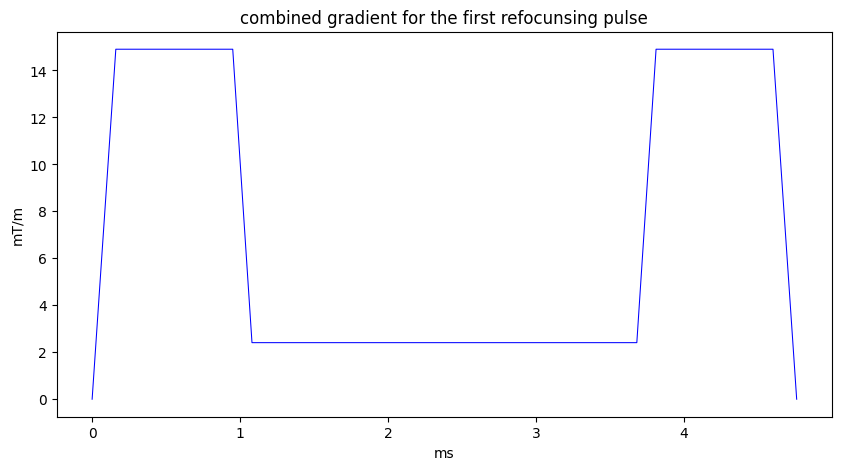

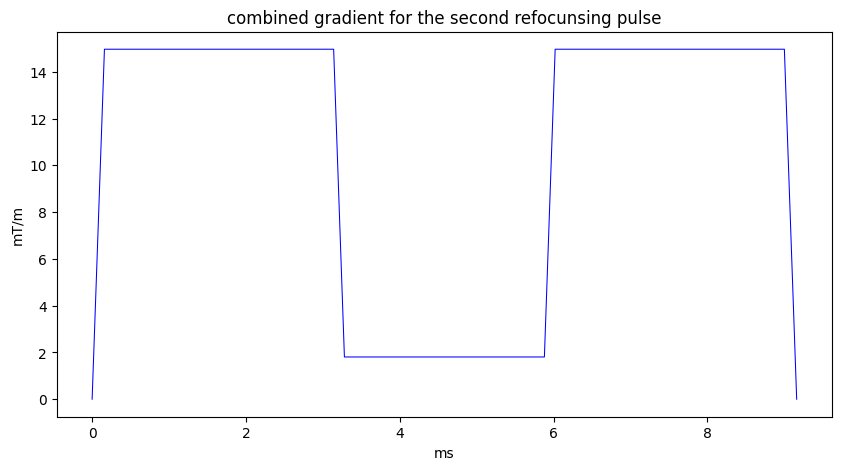

In [39]:
# join spoilers with the slice selection pulses of the refocusing gradients
# step 1: create pre-gradient to merge into the plato
g_ref1_pre,_,_ =mr.make_extended_trapezoid_area(channel=g_ref1.channel,grad_start=0,grad_end=g_ref1.amplitude,area=spA,system=system)
# step 2: create post-gradient to start at the plato
g_ref1_post,_,_=mr.make_extended_trapezoid_area(channel=g_ref1.channel,grad_start=g_ref1.amplitude,grad_end=0,area=spA,system=system)
# step 3: create a composite gradient
g_refC1=mr.make_extended_trapezoid(channel=g_ref1_pre.channel,
    times=     np.append(g_ref1_pre.tt,       g_ref1_post.tt+g_ref1_pre.shape_dur+g_ref1.flat_time),
    amplitudes=np.append(g_ref1_pre.waveform, g_ref1_post.waveform),
    system=system)
# see what we've got
plt.figure(figsize=(10, 5))
plt.plot(g_refC1.tt*1e3,g_refC1.waveform/system.gamma*1e3,'b-')
ax = plt.gca()
plt.title('combined gradient for the first refocunsing pulse')
plt.xlabel('ms')
plt.ylabel('mT/m')
plt.draw()
# same procedure for the second refocusing pulse slice selection
g_ref2_pre,_,_ =mr.make_extended_trapezoid_area(channel=g_ref2.channel,grad_start=0,grad_end=g_ref2.amplitude,area=spB,system=system);
g_ref2_post,_,_=mr.make_extended_trapezoid_area(channel=g_ref2.channel,grad_start=g_ref2.amplitude,grad_end=0,area=spB,system=system);
g_refC2=mr.make_extended_trapezoid(channel=g_ref2_pre.channel,
    times=     np.append(g_ref2_pre.tt,       g_ref2_post.tt+g_ref2_pre.shape_dur+g_ref2.flat_time),
    amplitudes=np.append(g_ref2_pre.waveform, g_ref2_post.waveform),
    system=system)
# update RF pulses' delays to center them on the central flat parts of the combined gradients
rf_ref1.delay=g_ref1_pre.shape_dur;
rf_ref2.delay=g_ref2_pre.shape_dur;
# see what we've got
plt.figure(figsize=(10, 5))
plt.plot(g_refC2.tt*1e3,g_refC2.waveform/system.gamma*1e3,'b-')
ax = plt.gca()
plt.title('combined gradient for the second refocunsing pulse')
plt.xlabel('ms')
plt.ylabel('mT/m')
plt.draw()


In [40]:
# now calculate other spoiler gradients
g_spAz1=mr.make_trapezoid(channel='z',area=spA,system=system)
g_spAz2=mr.make_trapezoid(channel='z',area=spA,system=system,delay=mr.calc_duration(g_spAz1)+g_ref1.flat_time)
g_spAx1=mr.make_trapezoid(channel='x',area=spA+g_exReph.area,system=system) # notice we reduce the area to account for slice refocusing
g_spAx2=mr.make_trapezoid(channel='x',area=spA,system=system,delay=mr.calc_duration(g_spAz1)+g_ref1.flat_time)
g_spBy1=mr.make_trapezoid(channel='y',area=spB,system=system)
g_spBy2=mr.make_trapezoid(channel='y',area=spB,system=system,delay=mr.calc_duration(g_spBy1)+g_ref2.flat_time)
g_spBx1=mr.make_trapezoid(channel='x',area=spB,system=system)
g_spBx2=mr.make_trapezoid(channel='x',area=spB,system=system,delay=mr.calc_duration(g_spBy1)+g_ref2.flat_time)
# combine spoilers to composite gradients
g_spAz=mr.add_gradients(grads=(g_spAz1,g_spAz2),system= system)
g_spAx=mr.add_gradients(grads=(g_spAx1,g_spAx2),system= system)
g_spBy=mr.add_gradients(grads=(g_spBy1,g_spBy2),system= system)
g_spBx=mr.add_gradients(grads=(g_spBx1,g_spBx2),system= system)
# update delays in g_refC1, g_refC2, rf_ref1 and rf_ref2 in case g_spAz1 is longer than g_ref1_pre
g_refC1.delay=g_refC1.delay-mr.calc_duration(g_ref1_pre)+mr.calc_duration(g_spAz1)
g_refC2.delay=g_refC2.delay-mr.calc_duration(g_ref2_pre)+mr.calc_duration(g_spBy1)
rf_ref1.delay=rf_ref1.delay-mr.calc_duration(g_ref1_pre)+mr.calc_duration(g_spAz1)
rf_ref2.delay=rf_ref2.delay-mr.calc_duration(g_ref2_pre)+mr.calc_duration(g_spBy1)
# end spoiler
end_sp_axes=['x','y','z']
g_spEnd=[None]*3
for i in range(3):
  g_spEnd[i] = mr.make_trapezoid(
    channel=end_sp_axes[i], system=system, area=1/1e-4 # spoiling area in inverse meters
  )

In [41]:
# Define delays and ADC events
delayTE1=1e-3 # this delay allows to shift the spin echo within the ADC window
# we define TE as 2* delay between the centers of the refocusing pulses
# delayTE2=TE/2-(mr.calcDuration(rf_ref1)-mr.calcRfCenter(rf_ref1)-rf_ref1.delay)-g_ref1_post.shape_dur-rf_ref2.delay-mr.calcRfCenter(rf_ref2)
delayTE2=TE/2 - rf_ref1.shape_dur/2 - g_ref1_post.shape_dur - rf_ref2.delay - rf_ref2.shape_dur/2
assert(delayTE2>=0)
# we start the ADC object right away after the spoiler
adc = mr.make_adc(num_samples=Nx,duration=adcDur,system=system)

#
delayTR=TR-max(mr.calc_duration(g_ex), mr.calc_duration(rf_ex))-mr.calc_duration(g_refC1)-delayTE1-delayTE2-mr.calc_duration(g_refC2)-mr.calc_duration(adc)-mr.calc_duration(g_spEnd[0]);
assert(delayTR>=0);

# Construct the sequence
Contruct the sequence object and fill it up block-by-block

In [42]:
seq = mr.Sequence(system)  # Create a new sequence object

# populate the sequence object with event blocks
# Loop over repetitions and define sequence blocks
for i in range(Nrep):
  seq.add_block(rf_ex,g_ex)
  seq.add_block(mr.make_delay(delayTE1))
  seq.add_block(rf_ref1,g_refC1,g_spAz,g_spAx)
  seq.add_block(mr.make_delay(delayTE2))
  seq.add_block(rf_ref2,g_refC2,g_spBy,g_spBx)
  seq.add_block(adc)

# Timing check
Check whether the sequence timing is OK and the objects are consistent and compatible with each other and the target scanner

In [43]:
(
    ok,
    error_report,
) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

Timing check passed successfully


# Visualize the sequence
Here we just plot the sequence timing. Due to the limitations of the Colab environment the plots are not live, no interactive zoom-in / zoom-out is possible, therefore it is necessary to use the time_range option

Plot the beginning of the sequence


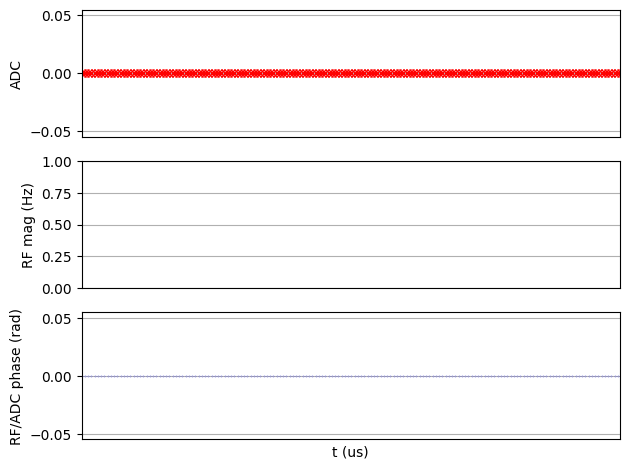

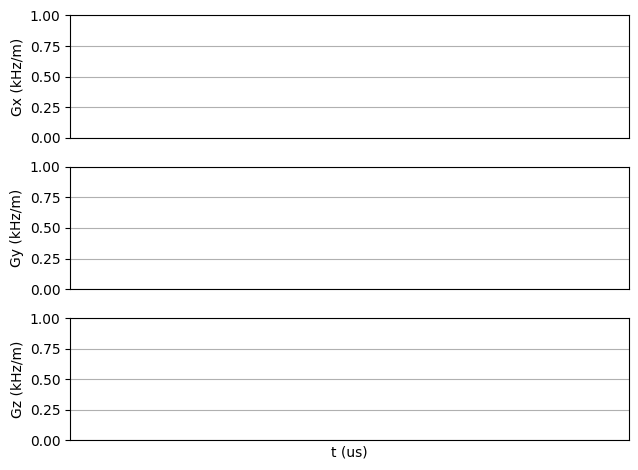

Plot of the entire sequence


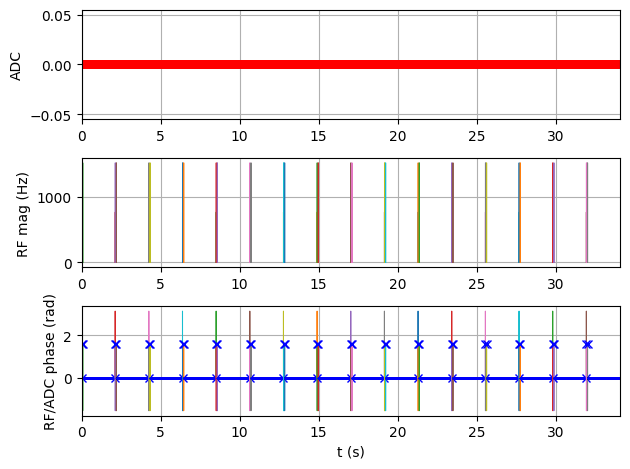

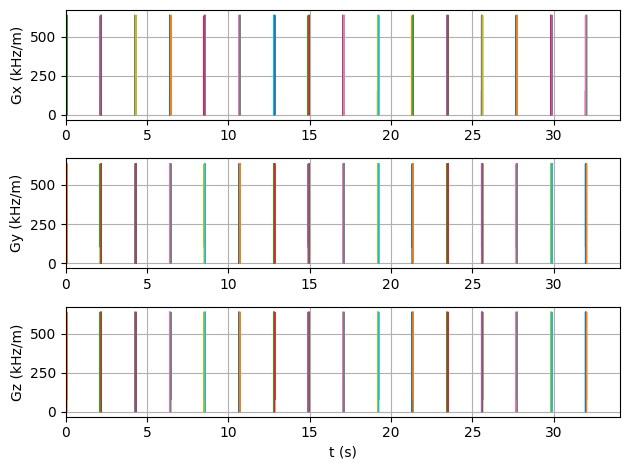

In [44]:
if plot:
  print("Plot the beginning of the sequence")
  seq.plot(time_range=[180000e-6, 262830e-6], time_disp="us", show_blocks=True) # just a small initial part

  #
  print("Plot of the entire sequence")
  seq.plot() # plot the entire sequence

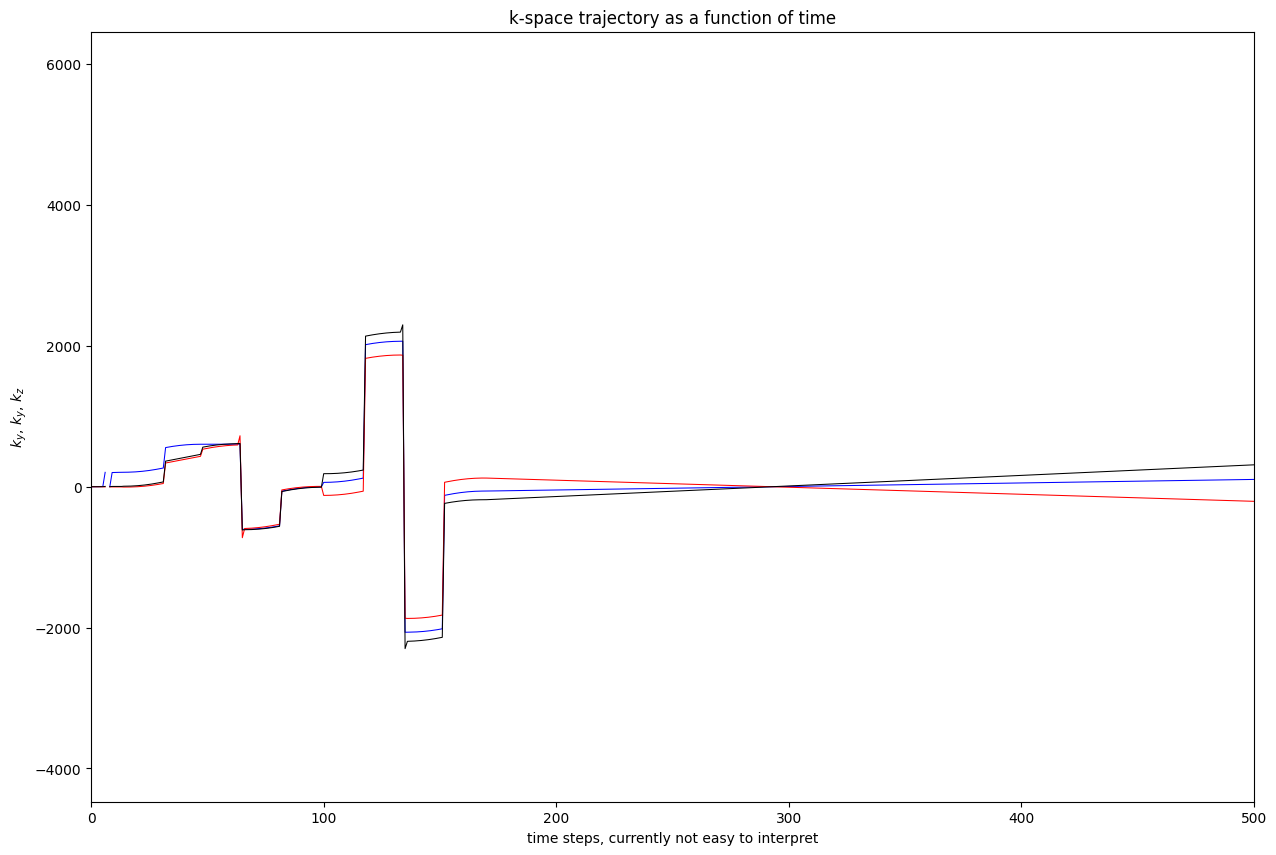

In [45]:
# no reason to calculate k-space, but we use the gradient_offset option to check the echo time ()
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace(gradient_offset=[1000,-2000,3000])
plt.figure(figsize=(15, 10))
plt.plot(k_traj[0,],'b-')
plt.plot(k_traj[1,],'r-')
plt.plot(k_traj[2,],'k-')
plt.xlim(0, 500) # you may need to change the upper limit but 500 gives a nice view for the default pulse sequence settings
ax = plt.gca()
plt.title('k-space trajectory as a function of time')
plt.xlabel('time steps, currently not easy to interpret')
plt.ylabel('$k_y$, $k_y$, $k_z$')
plt.draw()

# (Optionally) Analyze the sequence
Very optional slow step, but useful for testing during development
e.g. for the real TE, TR or for staying within slew-rate limits, etc.

In [46]:
rep = seq.test_report()
print(rep)

Number of blocks: 96
Number of events:
RF:     48
Gx:     48
Gy:     32
Gz:     32
ADC:     16
Delay:      0
Sequence duration: 34.076320 s
TE: 0.080600 s
TR: 2.129770 s
Flip angle: 90.00 180.00 deg
Unique k-space positions (aka cols, rows, etc.): 13 10 12 
Dimensions: 3
Spatial resolution: 283964779900.83 mm
Spatial resolution: 274877906944.00 mm
Spatial resolution: 136891387920.32 mm
Repetitions/slices/contrasts: 4096.0; range: [(4096.0, 8192.0)]
Non-cartesian/irregular encoding trajectory detected (eg: EPI, spiral, radial, etc.)
Event timing check passed successfully
Max gradient: 638298 636943 638298 Hz/m == 14.99 14.96 14.99 mT/m
Max slew rate: 4255319149 4246284501 4255319149 Hz/m/s == 99.95 99.73 99.95 T/m/s
Max absolute gradient: 1103423 Hz/m == 25.92 mT/m
Max absolute slew rate: 7.2776e+09 Hz/m/s == 170.93 T/m/s


#Write the .seq file

In [47]:
if write_seq:
  # Prepare the sequence output for the scanner
  seq.set_definition(key="FOV", value=voxel) # SVS spectroscopy should export the voxel via the FOV definition
  seq.set_definition(key="Name", value="press")
  # Write the sequence file
  seq.write(seq_filename)
  from google.colab import files
  files.download(seq_filename)  # Download locally

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exercises:
* add dummy scans to sequence loop
  - One plausible strategy is to start the loop counter from a negative value and avoid adding ADC to the corresponding sequence block
  - Remember however to add a dummy delay to this block to make sure that the duration of the block for the dummy cycles remains the same as for the acquisition scycles.
* add WET water suppression (with 3 Gaussian RF pulses and 3 crusher gradients)   
  - See  J Magn Reson B. 1994 May;104(1):1-10 (https://doi.org/10.1006/jmrb.1994.1048) for details.
  - Define parameters of WET sequence block (flip angles, RF dur/bandwidth, delays, gradient axes and areas)
  - Create pulses and crusher gradients
  - Include WET sequence block in the sequence loop

Optional exercises (no solution provided):
* replace RF pulses with SLR pulses
* add two phase encoding gradients to convert it to a CSI sequence